In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os as os
import sklearn
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing

%matplotlib inline

In [2]:
path_root = os.path.dirname(os.getcwd())
path_data = os.path.join(path_root, "dataset")
filename_data = os.path.join(path_data, "weather_prediction_dataset.csv")

In [3]:
data = pd.read_csv(filename_data)
data.head()


,DATE,MONTH,BASEL_cloud_cover,BASEL_humidity,BASEL_pressure,BASEL_global_radiation,BASEL_precipitation,BASEL_sunshine,BASEL_temp_mean,BASEL_temp_min,...,STOCKHOLM_temp_min,STOCKHOLM_temp_max,TOURS_wind_speed,TOURS_humidity,TOURS_pressure,TOURS_global_radiation,TOURS_precipitation,TOURS_temp_mean,TOURS_temp_min,TOURS_temp_max
0,20000101,1,8,0.89,1.0286,0.20,0.03,0.0,2.9,1.6,...,-9.3,0.7,1.6,0.97,1.0275,0.25,0.04,8.5,7.2,9.8
1,20000102,1,8,0.87,1.0318,0.25,0.00,0.0,3.6,2.7,...,0.5,2.0,2.0,0.99,1.0293,0.17,0.16,7.9,6.6,9.2
2,20000103,1,5,0.81,1.0314,0.50,0.00,3.7,2.2,0.1,...,-1.0,2.8,3.4,0.91,1.0267,0.27,0.00,8.1,6.6,9.6
3,20000104,1,7,0.79,1.0262,0.63,0.35,6.9,3.9,0.5,...,2.5,4.6,4.9,0.95,1.0222,0.11,0.44,8.6,6.4,10.8
4,20000105,1,5,0.90,1.0246,0.51,0.07,3.7,6.0,3.8,...,-1.8,2.9,3.6,0.95,1.0209,0.39,0.04,8.0,6.4,9.5


In [5]:
list({x.split("_")[0] for x in data.columns if x not in ["MONTH", "DATE"]})

['DRESDEN',
 'ROMA',
 'LJUBLJANA',
 'MUENCHEN',
 'DE',
 'MONTELIMAR',
 'MAASTRICHT',
 'DUSSELDORF',
 'STOCKHOLM',
 'SONNBLICK',
 'TOURS',
 'BUDAPEST',
 'PERPIGNAN',
 'HEATHROW',
 'KASSEL',
 'OSLO',
 'MALMO',
 'BASEL']

In [6]:
X_data = data.loc[:(data.shape[0]-2)].drop(columns=['DATE', 'MONTH'])
y_data = data.loc[1:]["STOCKHOLM_temp_max"]

predicted_labelname = "predicted max.temperature"
true_labelname = "true max.temperature"

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.3, random_state=0) 
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=0)

print(f"Data split into training ({X_train.shape[0]})," \
      f" validation ({X_val.shape[0]}) and test set ({X_test.shape[0]}).") 

Data split into training (2557), validation (548) and test set (548).


In [8]:
y_train[:10]

746      3.8
3188    16.5
1982    15.9
3396    11.9
2683    14.0
848      9.1
3328     0.5
1255    21.3
3618     7.9
3082    24.7
Name: STOCKHOLM_temp_max, dtype: float64

In [9]:
y_train.max(), y_train.min()


(32.6, -14.5)

In [10]:
X_train.shape, y_train.shape

((2557, 163), (2557,))

In [13]:
from tensorflow import keras
from tensorflow.keras.models import Model

def create_nn(n_features, n_predictions):
    # Input layer
    layers_input = keras.layers.Input(shape=(n_features,), name='input')

    # Dense layers
    layers_dense = keras.layers.BatchNormalization()(layers_input)
    layers_dense = keras.layers.Dense(100, 'relu')(layers_dense)
    layers_dense = keras.layers.Dropout(rate=0.2)(layers_dense, training=True)
    layers_dense = keras.layers.Dense(50, 'relu')(layers_dense)
    layers_dense = keras.layers.Dropout(rate=0.2)(layers_dense, training=True)
    layers_dense = keras.layers.Dense(10, 'relu')(layers_dense)

    # Output layer
    layers_output = keras.layers.Dense(n_predictions)(layers_dense)

    # Defining the model and compiling it
    return Model(inputs=layers_input, outputs=layers_output, name="dropout_prediction_model")

model = create_nn(X_data.shape[1], 1)
model.compile(loss='mse', optimizer=keras.optimizers.Adam(1e-4),
              metrics=[tf.keras.metrics.RootMeanSquaredError()])
model.summary()

Model: "dropout_prediction_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)                   │ (None, 163)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 163)                 │             652 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 100)                 │          16,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 50)                  │           5,050 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 10)                  │             510 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 22,623 (88.37 KB)

 Trainable params: 22,297 (87.10 KB)

 Non-trainable params: 326 (1.27 KB)

In [14]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Model

earlystopper = EarlyStopping(
    monitor='val_loss', mode="min",
    patience=20,
    verbose=1
    )

history = model.fit(X_train, y_train,
                    batch_size = 32,
                    epochs = 1000,
                    validation_data=(X_val, y_val),
                    callbacks=[earlystopper],
                    verbose = 2)

Epoch 1/1000
80/80 - 1s - 15ms/step - loss: 170.3114 - root_mean_squared_error: 13.0503 - val_loss: 93.5296 - val_root_mean_squared_error: 9.6711
Epoch 2/1000
80/80 - 0s - 1ms/step - loss: 103.8981 - root_mean_squared_error: 10.1930 - val_loss: 40.4501 - val_root_mean_squared_error: 6.3600
Epoch 3/1000
80/80 - 0s - 1ms/step - loss: 45.4948 - root_mean_squared_error: 6.7450 - val_loss: 24.5382 - val_root_mean_squared_error: 4.9536
Epoch 4/1000
80/80 - 0s - 1ms/step - loss: 32.9554 - root_mean_squared_error: 5.7407 - val_loss: 21.8962 - val_root_mean_squared_error: 4.6793
Epoch 5/1000
80/80 - 0s - 1ms/step - loss: 27.5521 - root_mean_squared_error: 5.2490 - val_loss: 19.1656 - val_root_mean_squared_error: 4.3779
Epoch 6/1000
80/80 - 0s - 1ms/step - loss: 25.6757 - root_mean_squared_error: 5.0671 - val_loss: 16.7240 - val_root_mean_squared_error: 4.0895
Epoch 7/1000
80/80 - 0s - 1ms/step - loss: 23.5696 - root_mean_squared_error: 4.8549 - val_loss: 14.7981 - val_root_mean_squared_error: 3

Epoch 59/1000
80/80 - 0s - 1ms/step - loss: 11.3703 - root_mean_squared_error: 3.3720 - val_loss: 6.0532 - val_root_mean_squared_error: 2.4603
Epoch 60/1000
80/80 - 0s - 1ms/step - loss: 10.2767 - root_mean_squared_error: 3.2057 - val_loss: 6.0337 - val_root_mean_squared_error: 2.4564
Epoch 61/1000
80/80 - 0s - 1ms/step - loss: 10.7549 - root_mean_squared_error: 3.2795 - val_loss: 6.1295 - val_root_mean_squared_error: 2.4758
Epoch 62/1000
80/80 - 0s - 1ms/step - loss: 10.4147 - root_mean_squared_error: 3.2272 - val_loss: 6.1734 - val_root_mean_squared_error: 2.4846
Epoch 63/1000
80/80 - 0s - 1ms/step - loss: 10.1317 - root_mean_squared_error: 3.1830 - val_loss: 6.0725 - val_root_mean_squared_error: 2.4642
Epoch 64/1000
80/80 - 0s - 1ms/step - loss: 9.7177 - root_mean_squared_error: 3.1173 - val_loss: 6.0092 - val_root_mean_squared_error: 2.4514
Epoch 65/1000
80/80 - 0s - 1ms/step - loss: 10.2940 - root_mean_squared_error: 3.2084 - val_loss: 5.9437 - val_root_mean_squared_error: 2.4380


Epoch 117/1000
80/80 - 0s - 1ms/step - loss: 8.8371 - root_mean_squared_error: 2.9727 - val_loss: 5.4446 - val_root_mean_squared_error: 2.3334
Epoch 118/1000
80/80 - 0s - 1ms/step - loss: 9.2624 - root_mean_squared_error: 3.0434 - val_loss: 5.4165 - val_root_mean_squared_error: 2.3273
Epoch 119/1000
80/80 - 0s - 1ms/step - loss: 9.8439 - root_mean_squared_error: 3.1375 - val_loss: 5.3677 - val_root_mean_squared_error: 2.3168
Epoch 120/1000
80/80 - 0s - 1ms/step - loss: 9.0024 - root_mean_squared_error: 3.0004 - val_loss: 5.3475 - val_root_mean_squared_error: 2.3125
Epoch 121/1000
80/80 - 0s - 1ms/step - loss: 9.4945 - root_mean_squared_error: 3.0813 - val_loss: 5.4808 - val_root_mean_squared_error: 2.3411
Epoch 122/1000
80/80 - 0s - 1ms/step - loss: 9.3807 - root_mean_squared_error: 3.0628 - val_loss: 5.4521 - val_root_mean_squared_error: 2.3350
Epoch 123/1000
80/80 - 0s - 1ms/step - loss: 9.0399 - root_mean_squared_error: 3.0066 - val_loss: 5.4166 - val_root_mean_squared_error: 2.3274

Epoch 175/1000
80/80 - 0s - 1ms/step - loss: 8.2089 - root_mean_squared_error: 2.8651 - val_loss: 5.1080 - val_root_mean_squared_error: 2.2601
Epoch 176/1000
80/80 - 0s - 1ms/step - loss: 8.6156 - root_mean_squared_error: 2.9352 - val_loss: 5.1013 - val_root_mean_squared_error: 2.2586
Epoch 177/1000
80/80 - 0s - 1ms/step - loss: 9.6151 - root_mean_squared_error: 3.1008 - val_loss: 5.5133 - val_root_mean_squared_error: 2.3480
Epoch 178/1000
80/80 - 0s - 1ms/step - loss: 8.9661 - root_mean_squared_error: 2.9943 - val_loss: 5.2379 - val_root_mean_squared_error: 2.2886
Epoch 179/1000
80/80 - 0s - 1ms/step - loss: 8.7412 - root_mean_squared_error: 2.9565 - val_loss: 5.0666 - val_root_mean_squared_error: 2.2509
Epoch 180/1000
80/80 - 0s - 1ms/step - loss: 8.0117 - root_mean_squared_error: 2.8305 - val_loss: 5.4331 - val_root_mean_squared_error: 2.3309
Epoch 181/1000
80/80 - 0s - 1ms/step - loss: 8.4333 - root_mean_squared_error: 2.9040 - val_loss: 5.1708 - val_root_mean_squared_error: 2.2739

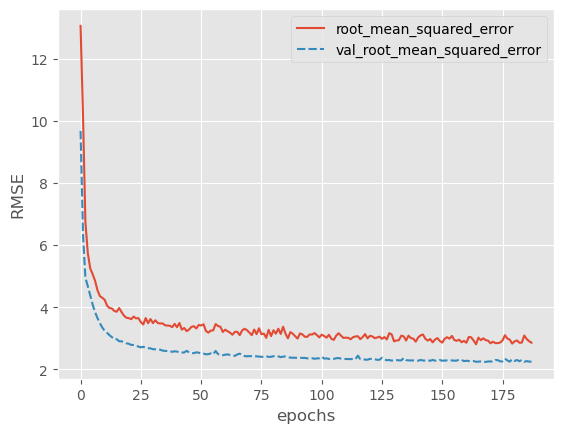

In [15]:
import seaborn as sns
plt.style.use('ggplot')
history_df = pd.DataFrame.from_dict(history.history)
sns.lineplot(data=history_df[['root_mean_squared_error', 'val_root_mean_squared_error']])
plt.xlabel("epochs")
plt.ylabel("RMSE")
plt.savefig("rmse_stockholm_plt.png", dpi=300)


80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 499us/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step


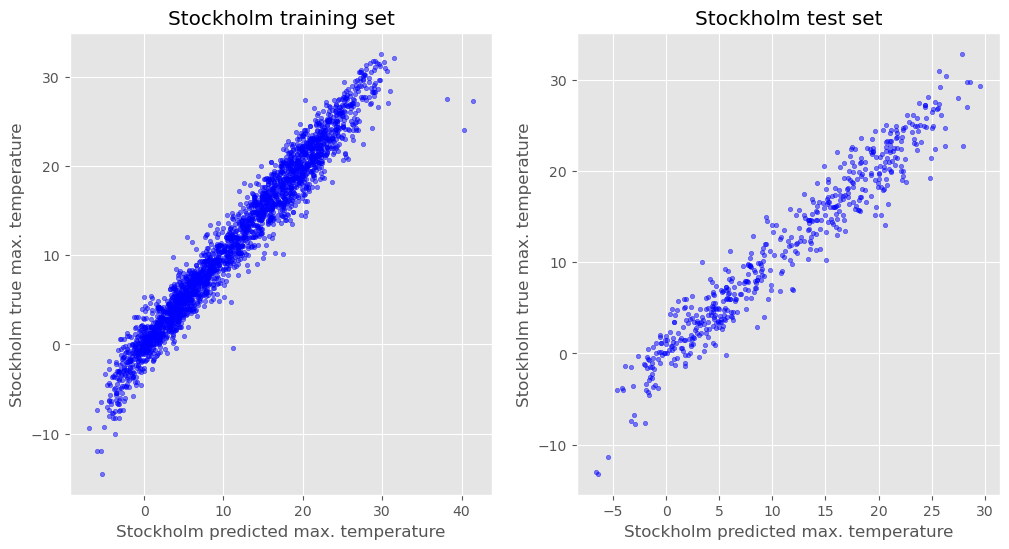

In [18]:
# Predict the sunshine hours
y_train_predicted = model.predict(X_train)
y_test_predicted = model.predict(X_test)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
plt.style.use('ggplot')
axes[0].scatter(y_train_predicted, y_train, s=10, alpha=0.5, color="blue")
axes[0].set_title("Stockholm training set")
axes[0].set_xlabel("Stockholm predicted max. temperature")
axes[0].set_ylabel("Stockholm true max. temperature")

axes[1].scatter(y_test_predicted, y_test, s=10, alpha=0.5, color="blue")
axes[1].set_title("Stockholm test set")
axes[1].set_xlabel("Stockholm predicted max. temperature")
axes[1].set_ylabel("Stockholm true max. temperature")
plt.savefig("stockholm_max_temperature_plot.png", dpi=300)
